# Automated Fatal Encounter Modeler Final Notebook Submission

### Notebook Outline
#### Introduction
   - Fatal Encounter defined
   - The Purpose
    
#### End user specification
   - Who they are

#### Data Wrangling
   - Data Importing & wrangling

#### Data Analysis

#### What is fbProphet, Why fbProphet, What about ARIMA 
- Model Preprocessing 
- Model Hyperparameter Tuning/Selection/Prediction
- Model Evaluation
    - prediction comparisons  

#### Residual comparisons
- Dataframe of actual Fatal Encounters returned
    
- End users specification 2
    - Key points for end-users to take advantage of from the viewpoints of: 
        - Law Enforcement oversight agencies
        - Civil non-profits
        - Local law enforcement agencies
    - Some examples of how a feedback loop increasing transparency, accountability, and community trust. Which I believe will lead to more communities being open to releasing information to law enforcement and increased glorification of the role so that we encourage people to become part of a public service that maintains the safety of all civilians and including law enforcement agents.

### Introduction

Fatal Encounter Defined

Fatal Encounter - an encounter in which a US civilian met with some law enforcement agencies and the civilian died during the encounter ** Does not include civilians who died in law enforcement custody **

The Purpose

The goal of this work is to provide a look into what has happened regarding civilian fatal encounters with police over the last 20 years by region and to predict what may happen based on the trends and seasonality we have already observed. It is my hope that this information will enlighten civilians and law enforcement, and overseeing agencies of the risk of ignoring problems in policing, not only as it pertains to minority groups, but as it pertains to all the stakeholders regarding the crucial work of policing. These encounters, when negatively viewed by the public make the line of this work more dangerous, but comprehensive reporting and analytics regarding this matter on a national scale is scarce. That may be because there are over 10,000 law enforcement agencies and major inconsistencies in reporting which lends itself to the unhealthy narrative of secrecy regarding public policing. “Secrecy in police work is not only undesirable but unwarranted. Accountability means being responsive to the problems and needs of citizens. It also means managing police resources in the most cost-effective manner. It must be remembered that the power to police comes from the consent of those being policed.” The Community Relations Service (CRS), a component of the U.S. Department of Justice.

### End User Specification
This product was designed for: 
- Nonprofit Organizations interested in policing transparency and quality policing
- Government Agencies to use an accountability and problem detection tool to prompt further investigations into law enforcement agencies that may end in local law enforcement policies and recommendations for resources to deal with the rise of national, statewide, and local issues to ensure the efficiency of services rendered to the public
- The General US public because they have a right to know and as mentioned by CRS of the Department of Justice, "Secrecy in police work is not only undesirable but unwarranted."

### Data Importation and Wrangling

In [1]:
# Importing Notebook Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.graph_objs as go
import itertools 
from fbprophet import Prophet
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf as pacf
from scipy.stats import normaltest
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import ParameterGrid
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from datetime import datetime, timedelta, date
from urllib.parse import quote
import time
import holidays
import random
import warnings
from scipy.stats import skew, kurtosis

In [2]:
# Importing Dataset
gsheetid = r'1dKmaV_JiWcG8XBoRgP8b4e9Eopkpgt7FL7nyspvzAsE'
sheet_name = quote('Form Responses', safe='')
gsheet_url = r"https://docs.google.com/spreadsheets/d/{}/gviz/tq?tqx=out:csv&sheet={}".format(gsheetid, sheet_name)
df = pd.read_csv(gsheet_url)

C:\Users\latee\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (15,20,21,22,23,24,35,37,38,39,40,41,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Transforming Dataset
    #  Casting columns in lowercase
df.columns = map(lambda x: x.lower(), df.columns)

    # Casting new column names
df = df.rename(columns={'location of death (city)' : 'city', 'location of death (county)' : 'county',
                        'location of death (zip code)':'zipcode',"date of injury resulting in death (month/day/year)":"date"})

    # Filling in missing data points in observations with values that doesn't obscure data
df = df.fillna(value={'location of death (city)':'unspecified',
                      'location of death (county)':'unspecified'})

In [4]:
# Creating National Time Series Dataframe 
    # This implies that the resulting dataframe will be in the datetime format
    # This also implies that the only column will be a count of fatal encounters per day
ld = list(df.date)
ld1 = pd.to_datetime(ld)
ld2 = pd.Series(ld1.to_period('d'))
ts = ld2.value_counts().sort_index().reset_index()
ts.columns = ['date', 'count']
ts.date = ts.date.dt.strftime('%m-%d-%Y')
ts.index = pd.to_datetime(ts.date)
tss = ts.drop('date', axis=1)

# This had to be a added to drop the invalid date they have in their google sheet as a spacer
tsss = tss[:-1]
# The days in which no fatal encounters occured is not 
# Eplixcitly stated in the original dataset so they are filled in with the below calls
all_dates = pd.date_range(start='2000/01/01', end=tsss.index.max(), freq='D')
national = tsss.reindex(all_dates, fill_value=0)

Just a quick check to make sure we got what we expected.

In [5]:
print('-'*60)
print('*** Head of the National dataframe ***')
print('-'*60)
print(national.head())
print('-'*60)
print('*** Tail of the National dataframe ***')
print('-'*60)
print(national.tail())

------------------------------------------------------------
*** Head of the National dataframe ***
------------------------------------------------------------
            count
2000-01-01      4
2000-01-02      6
2000-01-03      3
2000-01-04      0
2000-01-05      6
------------------------------------------------------------
*** Tail of the National dataframe ***
------------------------------------------------------------
            count
2021-02-10      7
2021-02-11     10
2021-02-12      4
2021-02-13      5
2021-02-14      2


In [6]:
# Function that takes a Dataframe and a column header to creates a new dictionary of dateframes based on column headers & unique value counts
    # Remember the global variable all_dates = pd.date_range(start='2000/01/01', end="last date in national dataframe", freq='D')
def output_ts_dict(df, column_header):
    # Check if column header is in df
        # If so, append every unique value of that Series to the list "unique_values"
    unique_values = []
    if column_header in df:
        unique_values.append(df[column_header].unique())
    else:
        return print('Column header not found')
    
    # Create a DataFrame of Series's containing a boolean mask for each item in "unique_values"
    masks = pd.DataFrame()
    for items in unique_values:
        for item in items:
            masks[item] = df[column_header] == item
    
    # Create a Dictionary of DataFrames one for each Series in the DataFrame masks
    dict_dfs = {}
    for columns in masks.columns:
        dict_dfs[columns] = df[masks[columns]]
    
    # Create a Dicitonary that stores the info needed for the TimeSeries-DataFrame
    dict_dfs001 = {}
    for item in dict_dfs.keys():
        dict_dfs001[item] = dict_dfs[item]['date']
    
    # Creating a Dictionary to hold TimeSeries-DataFrames and Performing Transformations that make them easy to use out of the Function
    dict_dfs002 = {}
    for count, key in enumerate(dict_dfs001):
        lister = list(dict_dfs001[key])
        date_lister = pd.to_datetime(lister)
        series_lister = pd.Series(date_lister.to_period('d'))
        time_series = series_lister.value_counts().sort_index().reset_index()
        time_series.columns = ['date', 'count']
        time_series.date = time_series.date.dt.strftime('%m-%d-%Y')
        time_series.index = pd.to_datetime(time_series.date)
        key_add = time_series.drop('date', axis=1)
        dict_dfs002[key] = key_add
        dict_dfs002[key] = dict_dfs002[key].reindex(all_dates, fill_value=0)
    return dict_dfs002

In [7]:
# Creating a dictionary of time series dataframes (one state per dataframe) 
states = output_ts_dict(df, 'state')

In [8]:
print('-'*60)
print('*** Head of dataframe for California ***')
print('-'*60)
print(states['CA'].head())
print('-'*60)
print('*** Tail of dataframe for California ***')
print('-'*60)
print(states['CA'].tail())

------------------------------------------------------------
*** Head of dataframe for California ***
------------------------------------------------------------
            count
2000-01-01      1
2000-01-02      1
2000-01-03      0
2000-01-04      0
2000-01-05      0
------------------------------------------------------------
*** Tail of dataframe for California ***
------------------------------------------------------------
            count
2021-02-10      1
2021-02-11      0
2021-02-12      3
2021-02-13      1
2021-02-14      0


Now, let's compare our California df to the National one, what we want to ensure is that the dates and times included are the same range. 

In [9]:
print(national.info())
print('\n'*2)
print(states['CA'].info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7716 entries, 2000-01-01 to 2021-02-14
Freq: D
Data columns (total 1 columns):
count    7716 non-null int64
dtypes: int64(1)
memory usage: 120.6 KB
None



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7716 entries, 2000-01-01 to 2021-02-14
Freq: D
Data columns (total 1 columns):
count    7716 non-null int64
dtypes: int64(1)
memory usage: 120.6 KB
None


### Data Analysis

In [10]:
# Function to create dataframe that breaks up the different aspects of dates of fatal encounters out into columns
def date_features(df, label=None):
    df = df.copy()
    
    df['date'] = df.index
    df['month'] = df['date'].dt.strftime('%B')
    df['year'] = df['date'].dt.strftime('%Y')
    df['dayofweek'] = df['date'].dt.strftime("%A")
    df['quarter'] = df['date'].dt.quarter
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['dayofweek', 'quarter', 'month', 'year',
            'dayofyear', 'dayofmonth', 'weekofyear']]
    
    if label:
        y = df[label]
        return X, y
    return 

X, y = date_features(national, label='count')
df_national_time = pd.concat([X, y], axis=1)

The following plots display:

- The sum of Fatal Encounters per year for every year we have
- Bar plot of average Fatal Encounters per year for each quarter
- Bar plot of average Fatal Encounters per year for each day of the week

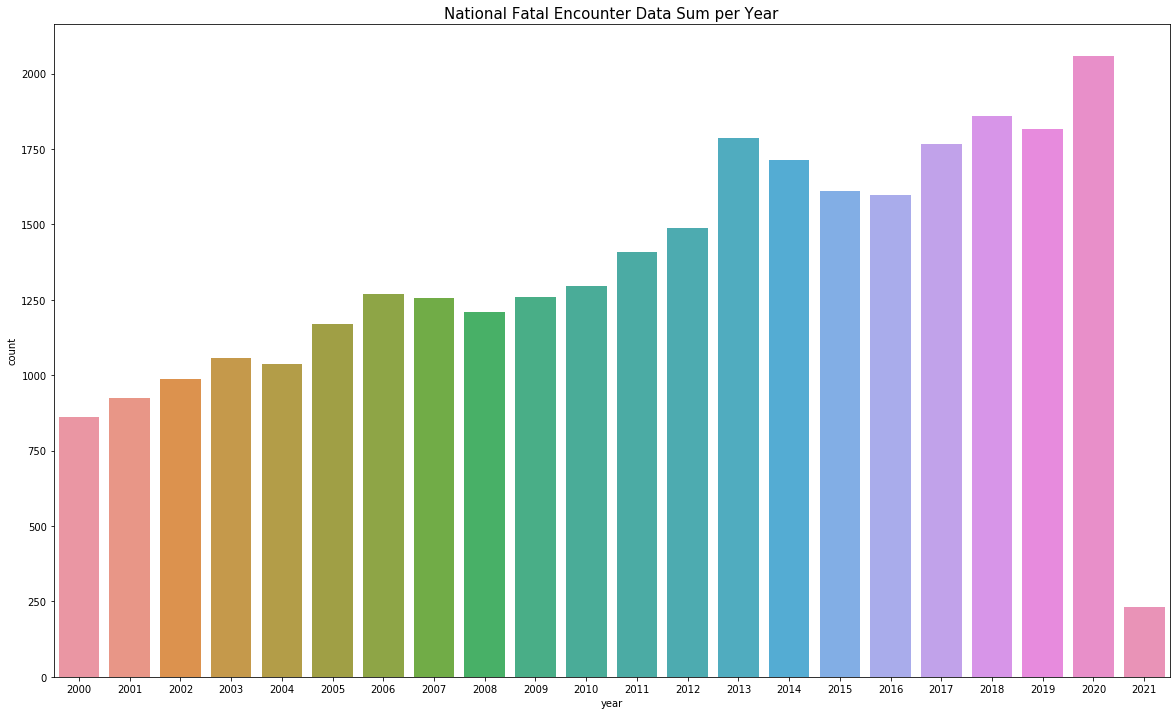

In [11]:
fig, ax = plt.subplots(figsize=(20,12))
yearaggregated = pd.DataFrame(df_national_time.groupby("year")["count"].sum()).reset_index()
a = sns.barplot(data=yearaggregated, x="year", y="count")
a.set_title("National Fatal Encounter Data Sum per Year", fontsize=15)
plt.show()

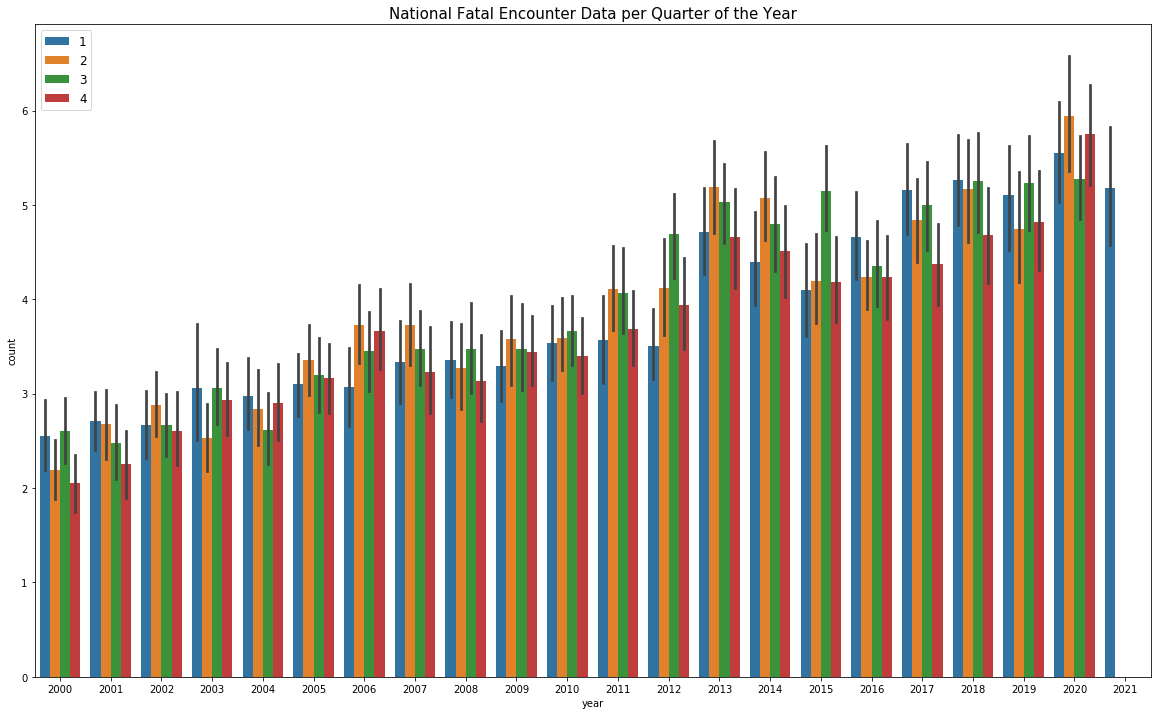

In [12]:
fig, ax = plt.subplots(figsize=(20,12))
a = sns.barplot(x= "year", y= "count", hue = 'quarter', data = df_national_time)
a.set_title("National Fatal Encounter Data per Quarter of the Year", fontsize=15)
plt.legend(loc='best', prop={'size': 12})
plt.show()

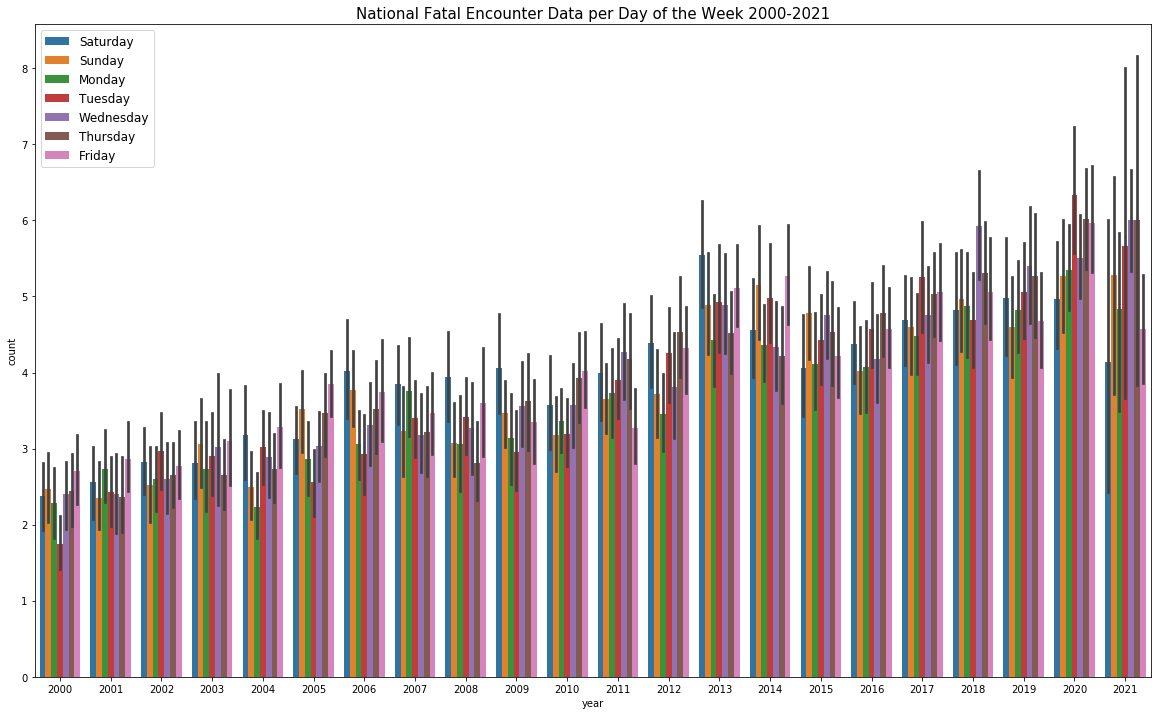

In [13]:
fig, ax = plt.subplots(figsize=(20,12))
a = sns.barplot(x= "year", y= "count", hue = 'dayofweek', data = df_national_time)
a.set_title("National Fatal Encounter Data per Day of the Week 2000-2021", fontsize=15)
plt.legend(loc='best', prop={'size': 12})
plt.show()

### Data Analysis continued...

#### Stationarity test (Adjusted Dickey Fuller Test), Normal test, & Histogram

A quick note about the data - due to the nature of this type of data as we zoom in on states, cities, counties, and zip codes the more zeros tend to appear in the dataset, and less fatal encounters creating more stationary Time Series Sets.

In [14]:
# Function to test stationarity, plot rolling mean, avg, and varience
def test_stationarity(timeseries, title):
    
    # Determining Rolling Statistics
    rolmean = timeseries.rolling(window=365).mean()
    rolstd = timeseries.rolling(window=365).std()
    rolvar = timeseries.rolling(window=365).var()
    
    # Plot Rolling Statistics
    fig, ax = plt.subplots(figsize=(20,12))
    a = plt.plot(timeseries, color='blue', label='Original')
    a = plt.plot(rolmean, color='red', label='Rolling Mean')
    a = plt.plot(rolstd, color='black', label='Rolling STD')
    a = plt.plot(rolvar, color='orange', label='Rolling Variance')
    a = plt.legend(loc='best')
    ax.set_title(title, fontsize=15)
    plt.show(block=False)
    
    # Perform Dickey-Fuller test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.iloc[:,0].values, autolag='AIC')
    dfoutput = pd.Series(dftest[:4], index=['Test Statistic', 'p-value', '#Lags Used',
                                            'Number of Oberservations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

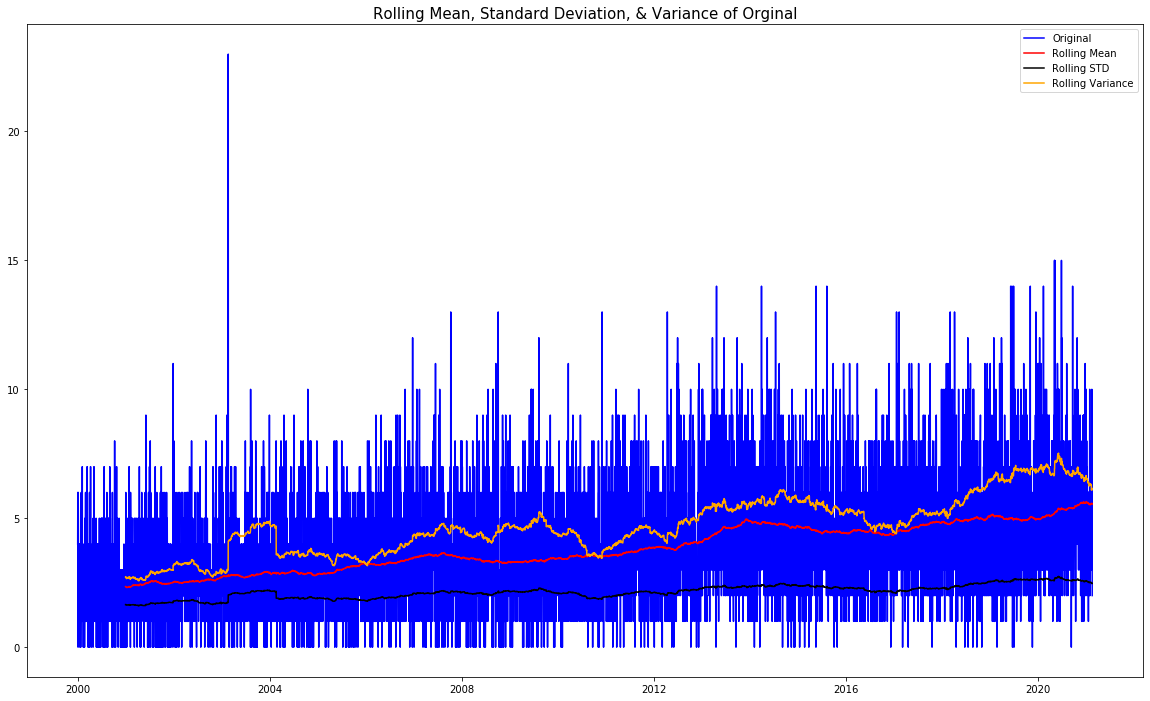

Results of Dickey-Fuller Test:
Test Statistic                     -5.083531
p-value                             0.000015
#Lags Used                         36.000000
Number of Oberservations Used    7679.000000
Critical Value (1%)                -3.431202
Critical Value (5%)                -2.861916
Critical Value (10%)               -2.566970
dtype: float64


In [15]:
test_stationarity(national, 'Rolling Mean, Standard Deviation, & Variance of Orginal')

The extremely long right tail observed below is a pretty common feature of these types of time series.

Test Statistic of National from a Normal test: [906.80261977]
p_value of National from a Normal test: [1.23115584e-197]

             count
count  7716.000000
mean      3.844349
std       2.346743
min       0.000000
25%       2.000000
50%       4.000000
75%       5.000000
max      23.000000





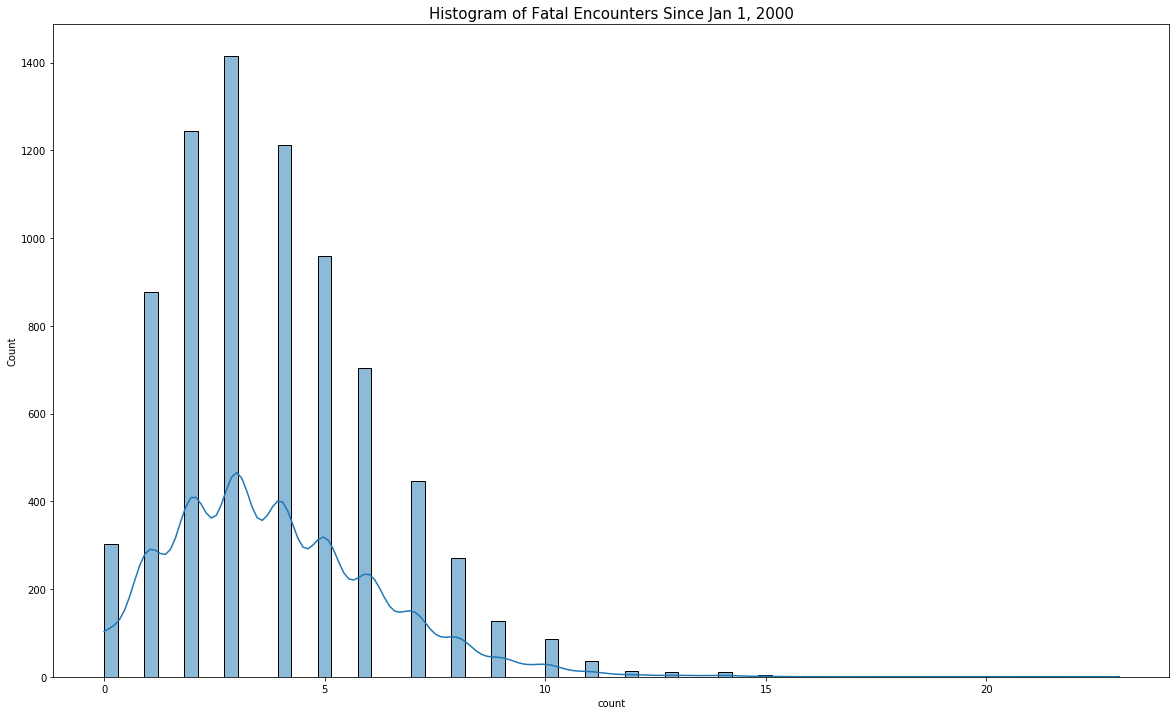

In [16]:
# Performing Normal Test, plotting histogram, 
fig, ax = plt.subplots(figsize=(20,12))
a = sns.histplot(data=national, x="count", kde=True)
a.set_title("Histogram of Fatal Encounters Since Jan 1, 2000", fontsize=15)
stat, p_ = normaltest(national)

print('Test Statistic of National from a Normal test:', stat)
print('p_value of National from a Normal test:', p_)
print()
print(national.describe())
print('\n'*2)

### What is fbProphet, Why not just ARIMA

#### What is fbProphet?

Facebook Prophet is an open-source time-series library that simplifies time series forecasting with the intention of putting high-quality time series forecasts in the hands of people who could use them without them running into the barrier to entry of high technical understanding. 
On a high level, it is an additive model of components that may or may not be linear. The first component is a piecewise trend which can be linear or logistic, the second component is seasonality, which is events that happen in a cyclical nature i.e. every month, the next piece is holidays, it’s events that happen that cause a major spike in the variable of interest without actually changing overall trend without the consideration of that event, and a smoothing factor for modeling the noise. For information on how the model works, I’d have to refer you to their explanation of how this works under the hood. https://peerj.com/preprints/3190.pdf 

Because the model is not generative we can’t claim that the upper yhat and lower yhat predictions guarantee confidence, but the distance of the upper and lower yhat bounds from the overall yhat value gives us a sense of how confident the model is at predicting into the future. 


#### Why not use an ARIMA model?

One of the reasons I did not compare the Prophet model to different configurations of the "tried and true" ARIMA model originally to predict Fatal Encounters for this specific product is related to the classical way that the parameter order (p,d,q) the ARIMA model is determined. Specifically the need to plot and analyze ACF and PACF graphs. But for the sake of this notebook and the presentation, I will consider a mix of ARIMA models as a comparison to the fbProphet model, but the final product will make use of fbProphet API.

Both the Autocorrelation and Partial Autocorrelation plots show weak to no correlation between a fatal encounter and previous fatal encounters. Typically if there was a higher correlation between a fatal encounter and previous fatal encounters, then I'd use events with at least a moderate correlation as a guide to help me determine the number of autoregressive and moving average terms to use in an ARIMA model. What I see from the below plots is that Autocorrelation is between 0.23 at about 1 and it trails to about 0.10 at about 1000. 

The PACF plot shows a weak autocorrelation from the first lag at about 0.18 and completely trails off after the 10th lag, but for the sake of modeling, I will only be concerned with the first 5 moving average terms. Also, I will only consider the first 5 autoregressive terms.

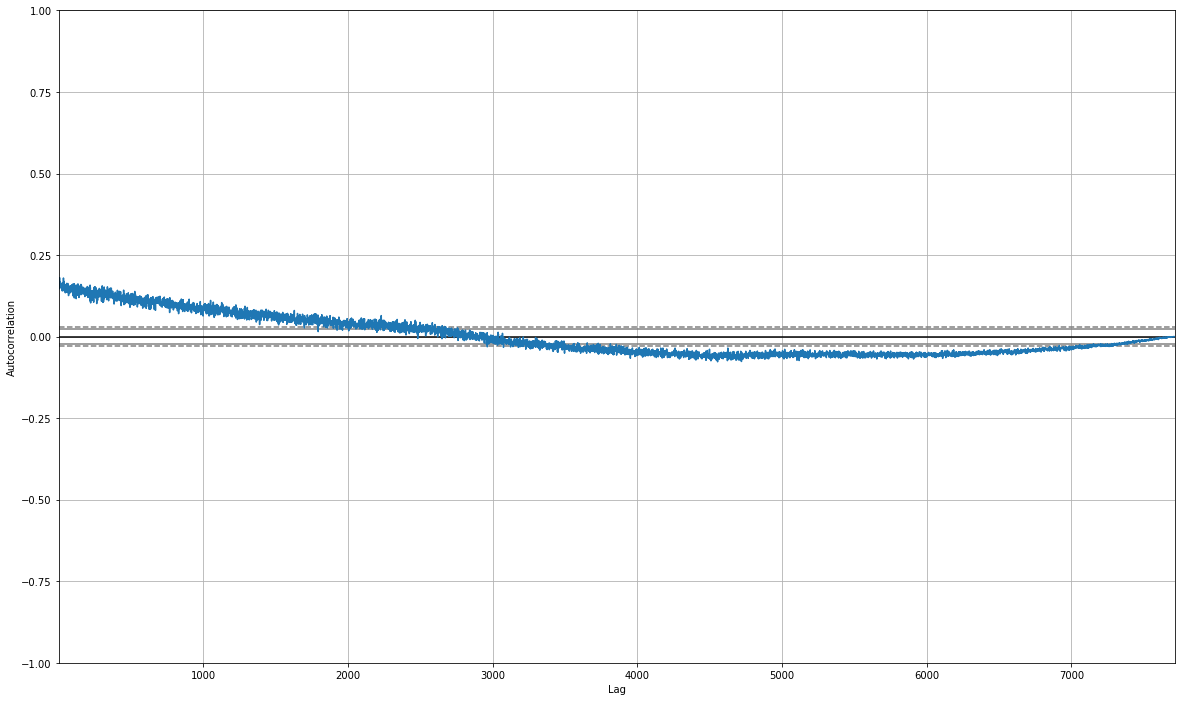

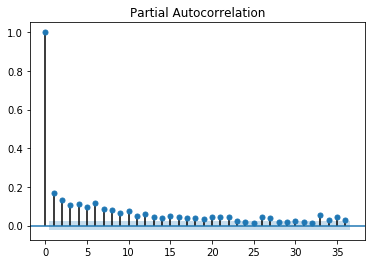

In [17]:
# Creating ACF Plot
plt.figure(figsize=(20,12))
autocorrelation_plot(national)
plt.show()
# Creating PACF
pacf(national, lags=36)
plt.show()

### Model - Preprocessing - Train_Test_Split

In essence, what I am going to do to test how the models perform on data outside of the training set data. Regardless of the date this report is requested, the model will predict the number of fatal encounters in the last 121 days we have available and the early portions of the dataset will be used for training. I will evaluate model performance based on mean absolute error and mean squared error. 

For the purpose of this notebook and the product itself, an additional 50 days will be predicted and plotted.

In [18]:
X, y = date_features(national, label='count')
df_national_time = pd.concat([X, y], axis=1)

In [19]:
model_df = pd.DataFrame({'ds' : df_national_time.index,
                         'y' : df_national_time['count']})

In [20]:
last_date = national.index.max()
start_date = last_date - timedelta(days=121)
mask1 = ((model_df['ds']<start_date) & (model_df['ds'] < last_date))

In [21]:
X_train = model_df.loc[mask1]
X_test = model_df.loc[-mask1]
print("Train Shape :", X_train.shape)
print("Test Shape :", X_test.shape)

Train Shape : (7594, 2)
Test Shape : (122, 2)


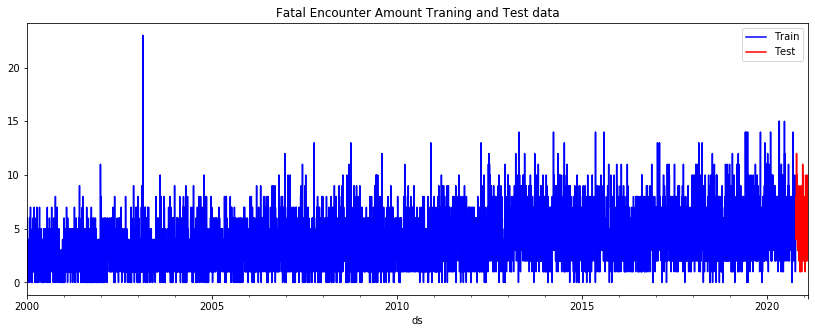

In [22]:
# plot to show how much of the data is used to train and how much is used to test
pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(14,5))
X_train.plot(kind='line', x='ds', y='y', color='blue', label='Train', ax=ax)
X_test.plot(kind='line', x='ds', y='y', color='red', label='Test', ax=ax)
plt.title('Fatal Encounter Amount Traning and Test data')
plt.show()

### Model Hyperparameter Tuning/Selection/Prediction

#### ARIMA

In [23]:
# Function to test and evaluate best order of ARIMA model to go with
def arima_training(df, orders):
    X = df['count'].values
    size = int(len(X) * 0.0158)
    train, arima_test = X[:-size], X[-size:]
    history = [x for x in train]
    arima_predictions = list()
    arima_model_parameters = pd.DataFrame()
    # Create and evaluate a model per model "order" or "config" passed in
    for order in orders:
        for t in range(len(arima_test)):
            model = ARIMA(history, order=order) 
            model_fit = model.fit()
            output = model_fit.forecast()
            yhat = output[0]
            arima_predictions.append(yhat)
            obs = arima_test[t]
            history.append(obs)
        # evaluate forecasts
        arima_mae = mae(arima_test, arima_predictions)
        arima_model_parameters = arima_model_parameters.append({'MAE':arima_mae, 'Parameters' :order}, ignore_index=True)
        arima_predictions = []
    return arima_model_parameters

In [24]:
# Creating ARIMA model configuration grid
configs = [(1,0,0), (2,0,0), (4,0,0), (5,0,0),
           (0,0,4), (0,0,3), (0,0,2), (0,0,1),
           (0,0,5), (0,0,4), (1,0,4), (1,0,3),
           (0,0,3), (2,0,2), (1,0,1), (2,0,1),
           (3,0,1), (4,0,1), (5,0,1)]
arima_parameters = arima_training(national, configs)

C:\Users\latee\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\latee\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [25]:
# Print best mmodel parameters choosen by "arima_training" function
    # Create new model using those params, and predict for 171 steps
        # The first 121 steps will be used for model scoring and evaluation 
arima_parameters = arima_parameters.sort_values(by='MAE')
arima_parameters = arima_parameters.reset_index(drop=True)
print('The best model parameters are:', arima_parameters['Parameters'][0])
X = national['count'].values
size = int(len(X) * 0.0158)
train, arima_test = X[:-size], X[-size:]
model = ARIMA(national[:-size], arima_parameters['Parameters'][0])
model_fit = model.fit()
arima_predictions, _, conf_int = model_fit.forecast(steps=171, alpha=0.05)
arima_predictions = arima_predictions.round()
# evaluate forecasts
arima_mae = mae(arima_test, arima_predictions[:121])
print('Test MAE: ', arima_mae)

The best model parameters are: (5, 0, 1)
Test MAE:  1.9173553719008265


#### fbProphet

In [26]:
params_grid = {'seasonality_mode': ('multiplicative','additive'),
               'changepoint_prior_scale': [0.1, 0.001, 0.01],
               'changepoint_range': [0.9, 0.8],
               'seasonality_prior_scale': [0.001, 0.1, 0.01],
               'holidays_prior_scale': [0.1, 0.3, 0.5],
               'n_changepoints' : [75, 25, 50],
               'uncertainty_samples' : [1500, 1000, 1250]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1
print('Total Possible Models',cnt)

Total Possible Models 972


In [27]:
model_parameters = pd.DataFrame(columns = ['MAE', 'Parameters'])
count = 0
for p in grid:
    test = pd.DataFrame()
    random.seed(0)
    train_model = Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                          n_changepoints = p['n_changepoints'],
                          uncertainty_samples = p['uncertainty_samples'],
                          seasonality_mode = p['seasonality_mode'],
                          seasonality_prior_scale = p['seasonality_prior_scale'],
                          changepoint_range = p['changepoint_range'],
                          holidays_prior_scale = p['holidays_prior_scale'],
                          daily_seasonality = True)
    train_model.add_country_holidays(country_name = 'US')
    train_model.fit(X_train)
    train_forecast = train_model.make_future_dataframe(periods=121, freq='D', include_history = False)
    train_forecast = train_model.predict(train_forecast)
    train_forecast['yhat_upper'] = round(train_forecast['yhat_upper'], 0)
    train_forecast['yhat'] = round(train_forecast['yhat'], 0)
    train_forecast['yhat_lower'] = round(train_forecast['yhat_lower'], 0)
    test = train_forecast[['ds', 'yhat']]
    Actual = model_df[(model_df['ds']>start_date) & (model_df['ds']<=last_date)]
    MAE = round(mae(Actual['y'],test['yhat']), 6)
    model_parameters = model_parameters.append({'MAE':MAE, 'Parameters' :p}, ignore_index=True)
    # If you'd like to see some model output from each model ran like the MAE score, the model count, and its parameters 
        # Remove the pound or hash symbol from the next 4 lines of code
#     print(p)
#     count += 1
#     print('model number :', count, 'MAE :', MAE)
#     print('-'*100)

Best model parameters for fbProphet are:

In [28]:
# Best Parameters are being selected and being ran again one last time for te final model
parameters = model_parameters.sort_values(by=['MAE'])
parameters = parameters.reset_index(drop=True)
print(parameters['Parameters'][0])
params = parameters['Parameters'][0]
final_model = Prophet(**params, daily_seasonality=False)
final_model.add_country_holidays(country_name='US')
final_model.fit(X_train)
future = final_model.make_future_dataframe(periods=171, freq='D')
forecast = final_model.predict(future)

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1500}


### Model Evaluation

Something to keep in mind is that because of how the fProphet model is constructed, we can not consider the upper and lower bounds to be a confidence interval but the further those estimations are from the prediction, the more uncertain the model is when predicting. On the other hand, when looking at the ARIMA model, those upper and lower bounds are considered to be a confidence interval at 95% confidence. This confidence interval is an obvious benefit to us ARIMA over fbProphet. Whereas the distance of the upper and lower bounds regarding the fbProphet model gives me a feeling for how confident the model is at its own predictions.

#### ARIMA Plot

In [29]:
# The upper and lower confidence intervals from the ARIMA function comes wrapped
    # This code unwraps that so we can plot it
super_wrapped = []
for i, tuples in enumerate(conf_int):
    for things in tuples:
        super_wrapped.append(things)
lower_interval = []
upper_interval = []
for i, stuff in enumerate(super_wrapped):
    if i == 0 or (i%2) == 0 :
        lower_interval.append(stuff.round())
    else:
        upper_interval.append(stuff.round())
# Using the index for X axis in plots
forecast.index = forecast['ds']

In [30]:
# Plot of Actual Fatal Encounters, Prediction from the model, Lower, and Upper yhat predictions
    # ARIMA model
fig = go.Figure([
    go.Scatter(
        name='Prediction',
        x=forecast.index[-182:],
        y=arima_predictions.round(),
        mode='lines',
        line=dict(color='rgb(255, 140, 0)'),
    ),
    go.Scatter(
        name='Upper Bound',
        x=forecast.index[-182:],
        y=upper_interval,
        mode='lines',
        marker=dict(color="#444"),
        line=dict(width=0),
        showlegend=False
    ),
    go.Scatter(
        name='Lower Bound',
        x=forecast.index[-182:],
        y=lower_interval,
        marker=dict(color="#444"),
        line=dict(width=0),
        mode='lines',
        fillcolor='rgba(68, 68, 68, 0.3)',
        fill='tonexty',
        showlegend=False
    ),
    go.Scatter(
        name='Actual',
        x=forecast.index,
        y=national['count'],
        mode='lines',
        line=dict(color='rgb(31, 119, 180)'),
    )])

fig.update_layout(
    yaxis_title='Count of Fatal Encounters',
    title='Fatal Encounters',
    hovermode="x")

fig.update_xaxes(rangeslider_visible=True)
fig.write_html('ARIMA.html', auto_open=True)

#### fbProphet Plot

In [31]:
# Plot of Actual Fatal Encounters, Prediction from the model, Lower, and Upper yhat predictions
    # fbProphet model
fig = go.Figure([
    go.Scatter(
        name='Prediction',
        x=forecast.index[-182:],
        y=round(forecast.iloc[-182:,-1], 0),
        mode='lines',
        line=dict(color='rgb(255, 140, 0)'),
    ),
    go.Scatter(
        name='Upper Bound',
        x=forecast.index[-182:],
        y=round(forecast.iloc[-182:,3], 0),
        mode='lines',
        marker=dict(color="#444"),
        line=dict(width=0),
        showlegend=False
    ),
    go.Scatter(
        name='Lower Bound',
        x=forecast.index[-182:],
        y=round(forecast.iloc[-182:,2], 0),
        marker=dict(color="#444"),
        line=dict(width=0),
        mode='lines',
        fillcolor='rgba(68, 68, 68, 0.3)',
        fill='tonexty',
        showlegend=False
    ),
    go.Scatter(
        name='Actual',
        x=forecast.index,
        y=national['count'],
        mode='lines',
        line=dict(color='rgb(31, 119, 180)'),
    )])

fig.update_layout(
    yaxis_title='Count of Fatal Encounters',
    title='Fatal Encounters',
    hovermode="x")

fig.update_xaxes(rangeslider_visible=True)
fig.write_html('fbProphet.html', auto_open=True)

As we can observe from the below scores these models are very close in overall predictive performance considering the 2 scoring metrics used. The rounding is done because the actual values are integers with no decimal places.

In [32]:
arima_predictions_df = pd.DataFrame({'yhat':arima_predictions})
print('fbProphet MAE Score :', mae(national.iloc[-121:], forecast['yhat'].iloc[-170:-49].round()).round(6))
print('ARIMA MAE Score :', mae(national.iloc[-121:], arima_predictions_df.iloc[:-50].round()).round(6))

fbProphet MAE Score : 1.909091
ARIMA MAE Score : 1.917355


In [33]:
print('fbProphet MSE Score :', mse(national.iloc[-121:], forecast['yhat'].iloc[-170:-49].round()).round(6))
print('ARIMA MSE Score :', mse(national.iloc[-121:], arima_predictions_df.iloc[:-50].round()).round(6))

fbProphet MSE Score : 6.190083
ARIMA MSE Score : 6.0


#### Models Residual Evaluation

The errors from an ideal model would resemble white noise, which is a Gaussian distribution with a mean of zero and display symmetrical variance. A non-Gaussian distribution may suggest an opportunity for data pre-processing. A skew in the distribution or a non-zero mean may suggest a bias in the forecasts.

Additionally, an ideal model would leave no temporal structure in the time series of forecast residuals. These can be checked by creating ACF and PACF plots of the residual error time series. The presence of serial correlation in the residual errors suggests a further opportunity for using this information in the model. For that reason, I'll plot the residuals using ACF and PACF plots. 

##### ARIMA Residual Evaluation

Text(0.5, 1.0, 'ARIMA Residuals Line Plot')

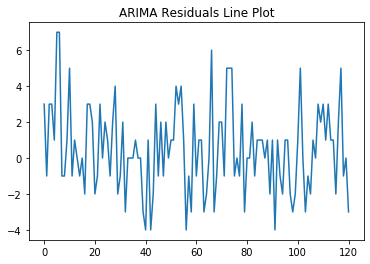

In [34]:
act = national.iloc[-121:]
arima_residuals = act.values - arima_predictions_df[:-50].round()
plt.plot(arima_residuals)
plt.title('ARIMA Residuals Line Plot')

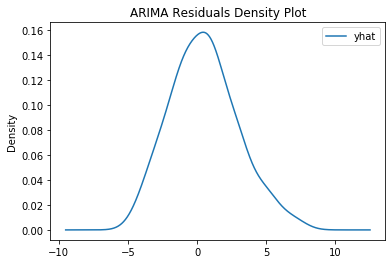

In [35]:
arima_residuals.plot(kind='kde', title='ARIMA Residuals Density Plot')

In [36]:
print('Skew of the ARIMA residuals is: ', skew(arima_residuals))
print('Kurtosis of the ARIMA residuals is: ', kurtosis(arima_residuals))

Skew of the ARIMA residuals is:  [0.37077377]
Kurtosis of the ARIMA residuals is:  [-0.12477759]


In [37]:
arima_residuals.describe()

,yhat
count,121.000000
mean,0.512397
std,2.405257
min,-4.000000
25%,-1.000000
50%,0.000000
75%,2.000000
max,7.000000


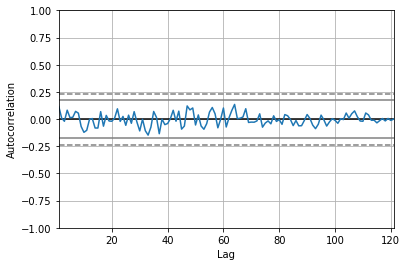

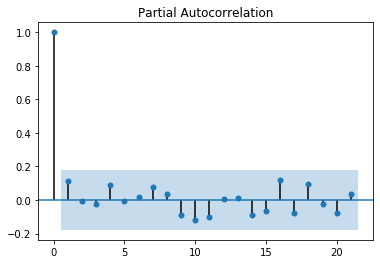

In [38]:
autocorrelation_plot(arima_residuals)
pacf(arima_residuals)
plt.show()

After looking at the above plots and statistics, there appears to be some bias in the model. The line plot shows a gradual downward trend. As we can see from the density plot, skew, and kurtosis the distribution of errors is not perfectly normal. The kurtosis in particular indicates that the distribution of errors has "long tails." On the other hand, the ACF and PACF plots suggest that we got as much useful information that we could from the previous observations of fatal encounters so that we are not leaving any pivotal previous observations out that could help us produce a better model. It also means that we are not breaking the OLS (ordinary least squares) assumption that, that errors are not correlated with themselves.

This leads me to believe that the model produced here is not perfect, but reasonable.

##### fbProphet Residual Evaluation

Text(0.5, 1.0, 'fbProphet Residuals Line Plot')

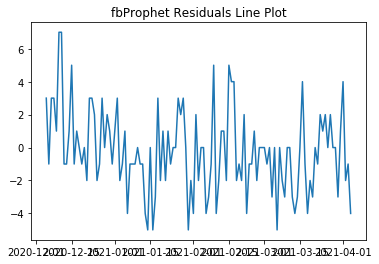

In [39]:
prophet_residuals = act.values - forecast.iloc[-121:,-1:].round()
plt.plot(prophet_residuals)
plt.title('fbProphet Residuals Line Plot')

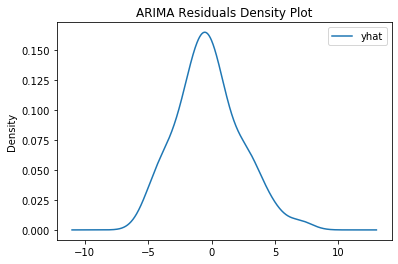

In [40]:
prophet_residuals.plot(kind='kde', title='ARIMA Residuals Density Plot')

In [41]:
print('Skew of the ARIMA residuals is: ', skew(prophet_residuals))
print('Kurtosis of the ARIMA residuals is: ', kurtosis(prophet_residuals))

Skew of the ARIMA residuals is:  [0.39706176]
Kurtosis of the ARIMA residuals is:  [0.07712863]


In [42]:
prophet_residuals.describe()

,yhat
count,121.000000
mean,-0.231405
std,2.522434
min,-5.000000
25%,-2.000000
50%,0.000000
75%,1.000000
max,7.000000


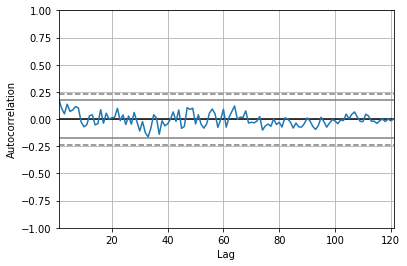

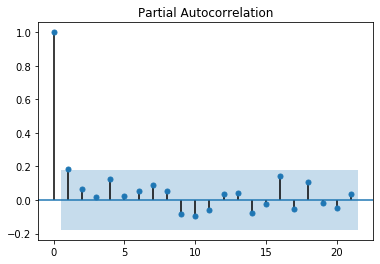

In [43]:
autocorrelation_plot(prophet_residuals)
pacf(prophet_residuals)
plt.show()

Upon observation of the fbProphet residual line plot, I see there is a similar gradual downward trend. As we can see from the density plot, skew, and kurtosis the distribution of errors of these residuals are not perfectly normal either. The of the fbProphet model mean is about 0.3 closer to zero, the fbProphet model residuals also have a slightly higher skew at around 0.01 higher than the ARIMA model, but has a higher kurtosis. The kurtosis is still over 2.0 away from three and also appears to have long tails. The ACF and PACF for the fbProphet model also look good, though the PACF plot for the ARIMA model appears to be slightly better than the fbProphet model's residuals.

#### Dataframe of actual Fatal Encounters returned

When using the product, a csv will be downloaded with every record of Fatal Encounters for the area of interest. For example, if someone requested a PA state report, then a data frame of the Fatal Encounters in PA will be returned. This is provided so that the public may investigate any one of these incidents.

#### National Trends

A way for viewers to observe trends with fbProphet.

Warning trends are meant to be observed with the other pieces of this tool. If that alone is used without considering how often fatal encounters happen within a certain area, then one might get the wrong idea.

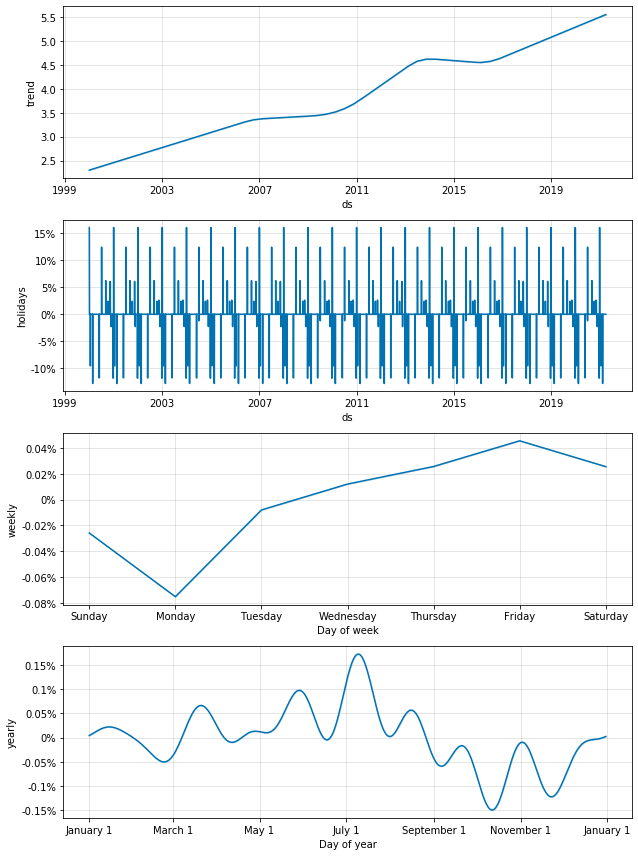

In [44]:
fig = final_model.plot_components(forecast)

### End users specification 2
    - Key points for end-users to take advantage of (from the viewpoints of a Law Enforcement oversight agency, civil rights/nonprofit organization, local law enforcement agency, and a U.S. citizen.)  
    
    - Agencies overseeing Law enforcement
        - Agencies overseeing law enforcement operations with an interest in maintaining and improving public trust in law enforcement could use these reports as a starting point for investigating "use of force" in very specific situations(referring to the returned data frame) and uncovering trends(referring to the components report). For example, if suicide is on the rise and these encounters are resulting in death then resources can be allocated to have professionals (with the proper negotiating skills) accompany law enforcement in those areas. In an attempt to address the problems of the public by thinking national, but responding to local situations. Needs investigations of this kind could be done on a local, state-wide, or national level depending on the jurisdiction of the agency.

    - Law Enforcement
        - I believe law enforcement agencies working along with an "outside" data organizer like FatalEncounter.org would benefit from making these reports public and quickly accessible so that the narrative of policing starts with honesty and transparency. If the data comes from law enforcement and is verified with other public sources then, people are more likely to trust it and those agencies over time, as long as there are no "conflicts of interest." 
    
    - Nonprofit and civil rights groups
        - Once the data is widely available then these groups could use it to create databases of incidents and results or amendments made to ensure fewer of these incidents occur by appealing to agencies for the need of consistent accountability. These organizations should also make their information open to the general public and as we progress towards being more routinely consistent this will also help reinforce public trust and transparency.
    
    - The American Public at large
        - This information is not being shared with the intention to scare people but to warn everyone that things are out of hand and it is dangerous not to track them. Notice that days without fatal encounters start to become rarer as we observe the time series plot Jan 1, 2000, to Dec 31, 2021.
    
I know the current political environment has polarized the US into putting policing into partisan hate or love perspective for a lot of people, but let's be honest we all want transparent law and order and equal treatment under the law. That is the idea that unites us, transparency, and accountability are how we get there. It's unlikely that public trust will be created or restored among every part of the US population immediately, but with transparency, accountability, and consistency over time, it is achievable.

### Future Work Recommendations

1. Coordinate with Fatal Encounters moderator and founder D. Brian Burghart to provide accurate and timely information on updates

1. possible add percent changes over time

1. In case there's no way to access FatalEncounters.org datasheet backup the last report seen

1. time series model evaluation with cross validation technique, forward chaining

1. Add the option to create a report for each agency regarding which agencies are involved with each fatal encounter

1. Have the model adjust based on the accuracy of prior estimates (deploy other ideas to help make the model more robust towards States, cities, counties, and zipcodes)

1. Searching for counties (a spellchecker or recommendation list)

1. The database of Fatal encounters may not be updated daily so unintentional errors may be observed regarding the time of the request and the recency of the information available

1. Cause of death information request - the cause of death was actually on the fatal encounters database when I started this project, but has since been removed. If that information was return then more robust information regarding each incident would be available to all of the groups mentioned above.

1. Do more to increase the speed of the program in general like
    - Rewrite the function "output_ts_dict()" to only create the information need for the report instead of creating a data frame for each unique value found in a column. For Example, if you requested the State of Texas, then every state is assigned a space in the returned dictionary. This becomes more time-consuming as one might ask for a city, county, or zip code.
    
1. Susceptible to failure if too much is changed to how the data is stored in the google sheet file used to retrieve the data